[INFO] Loading and processing test images...

Classification Report (in %):
              precision  recall  f1-score    support
angry             38.08   49.34     42.98   83500.00
fear              33.50   29.37     31.30   93300.00
happy             81.51   77.99     79.71  171300.00
neutral           48.98   40.81     44.53  118100.00
sad               37.31   41.77     39.41  109400.00
surprise          62.77   63.41     63.09   77900.00
accuracy          52.87   52.87     52.87      52.87
macro avg         50.36   50.45     50.17  653500.00
weighted avg      53.59   52.87     53.02  653500.00


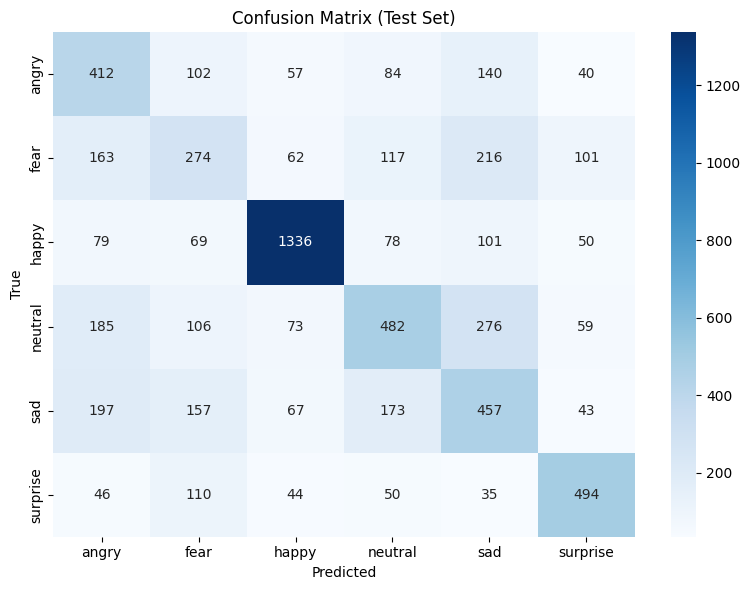

In [5]:
import os
import cv2
import mediapipe as mp
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

# Load trained MLP model, label encoder, and scaler
model = joblib.load('mlp_emotion_model_balanced.pkl')
label_encoder = joblib.load('label_encoder2.pkl')
scaler = joblib.load('scaler.pkl')

# Initialize MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

# Setup test directory
test_data_dir = 'test'
X_test = []
y_true = []
filenames = []

print("[INFO] Loading and processing test images...")

for label in os.listdir(test_data_dir):
    if label.lower() == 'disgust':
        continue  # Skip 'disgust' class

    label_folder = os.path.join(test_data_dir, label)
    if not os.path.isdir(label_folder):
        continue

    for img_file in os.listdir(label_folder):
        img_path = os.path.join(label_folder, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(img_rgb)

        if results.multi_face_landmarks:
            landmarks = results.multi_face_landmarks[0]
            coords = [coord for lm in landmarks.landmark for coord in (lm.x, lm.y)]
            X_test.append(coords)
            y_true.append(label)
            filenames.append(img_file)

# Convert lists to arrays
if len(X_test) == 0:
    print("[WARNING] No valid face landmarks detected in test images.")
else:
    X_test = np.array(X_test)
    y_true = np.array(y_true)

    # Encode true labels
    y_true_encoded = label_encoder.transform(y_true)

    # Scale features before prediction
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred_encoded = model.predict(X_test_scaled)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)

    # Classification report
    report = classification_report(
        y_true_encoded, y_pred_encoded,
        target_names=label_encoder.classes_,
        output_dict=True
    )

    # Convert to percentage format
    report_percent = {
        key: {metric: round(score * 100, 2) for metric, score in value.items()}
        if isinstance(value, dict) else round(value * 100, 2)
        for key, value in report.items()
    }

    report_df = pd.DataFrame(report_percent).transpose()
    print("\nClassification Report (in %):")
    print(report_df)

    # Confusion matrix
    cm = confusion_matrix(y_true_encoded, y_pred_encoded)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Test Set)')
    plt.tight_layout()
    plt.show()
